## RoI adust setting

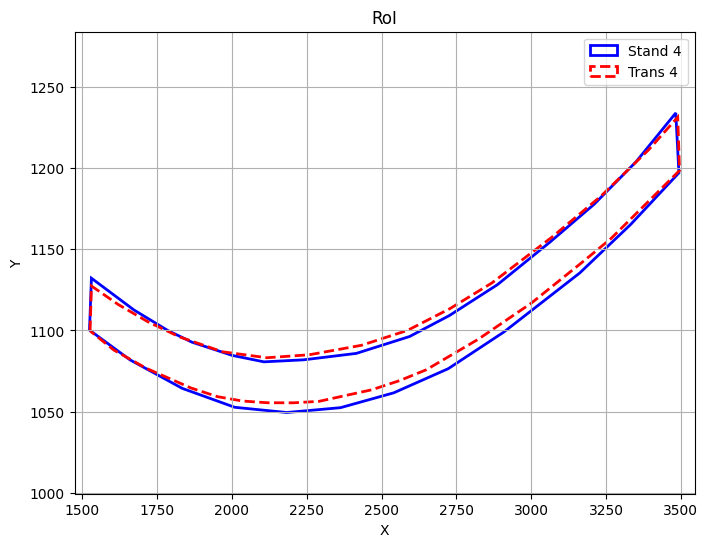

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib.patches import Polygon

# 1. Load RoI file
def load_roi(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# 2. Select specific Site, Zone, and Region
def get_regions(roi_data, site, zone, regions=None):
    zone_data = roi_data[site][zone]
    structured_polygons = {}
    for region_name, region in zone_data.items():
        if regions is None or region_name in regions:
            structured_polygons[region_name] = np.array(region)
    return structured_polygons

# 3. Transformation function (translation, rotation, scaling)
def transform_regions(regions, translation=(0,0), rotation=0, scale=1.0, rotation_center=None):
    transformed_regions = {}
    theta = np.radians(rotation)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta),  np.cos(theta)]])
    
    for region_name, region in regions.items():
        scaled_region = region * scale  # 1. Apply scaling

        if rotation_center is None:
            # By default, set the center to the mean coordinates of the polygon
            cx, cy = np.mean(scaled_region, axis=0)
        else:
            # The user can specify a custom center point
            cx, cy = rotation_center

        # 2. Move the center to the origin
        centered_region = scaled_region - np.array([cx, cy])

        # 3. Apply rotation
        rotated_region = np.dot(centered_region, rot_matrix.T)

        # 4. Move back to the original position
        translated_region = rotated_region + np.array([cx, cy])

        # 5. Apply final translation
        transformed_regions[region_name] = translated_region + np.array(translation)

    return transformed_regions

# 4. Visualization of results
def plot_regions(base_regions, transformed_regions):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for region_name, base_region in base_regions.items():
        base_polygon = Polygon(base_region, closed=True, edgecolor='blue', facecolor='none', linewidth=2, label=f'Stand {region_name}')
        ax.add_patch(base_polygon)
    
    for region_name, transformed_region in transformed_regions.items():
        transformed_polygon = Polygon(transformed_region, closed=True, edgecolor='red', facecolor='none', linewidth=2, linestyle='dashed', label=f'Trans {region_name}')
        ax.add_patch(transformed_polygon)
    
    ax.set_xlim(min(min(region[:,0].min() for region in base_regions.values()), min(region[:,0].min() for region in transformed_regions.values())) - 50, 
                max(max(region[:,0].max() for region in base_regions.values()), max(region[:,0].max() for region in transformed_regions.values())) + 50)
    ax.set_ylim(min(min(region[:,1].min() for region in base_regions.values()), min(region[:,1].min() for region in transformed_regions.values())) - 50, 
                max(max(region[:,1].max() for region in base_regions.values()), max(region[:,1].max() for region in transformed_regions.values())) + 50)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("RoI")
    ax.legend()
    ax.grid()
    plt.show()

roi_file = './geoalign_roi.json' 
data = load_roi(roi_file)

# Select two sites, zones, and regions for comparison
site1, zone1, selected_regions1 = 'Site F', 'E', ['4']
site2, zone2, selected_regions2 = 'Site F_raw', 'E', ['4']

base_regions = get_regions(data, site1, zone1, selected_regions1)
transformable_regions = get_regions(data, site2, zone2, selected_regions2)

# Parameters for transformation
translation = (-85, -39)  # x, y translation
rotation_center = None
rotation = 2.1  # Clockwise rotation (degrees)
scale = 1.06  # Scaling factor, default: 1

transformed_regions = transform_regions(transformable_regions, translation, rotation, scale, rotation_center)

# Visualize before and after transformation
plot_regions(base_regions, transformed_regions)

## GeoAlign tranformation

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import re
import pandas as pd

# 1. Load RoI file
def load_roi(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# 2. Select all Zones and Regions of a specific Site
def get_all_regions(roi_data, site):
    site_data = roi_data.get(site, {})
    structured_polygons = {}
    
    for zone, zone_data in site_data.items():
        for region_name, region in zone_data.items():
            structured_polygons[(zone, region_name)] = np.array(region)
    
    return structured_polygons

def transform_regions(regions, transform_params):
    transformed_regions = {}
    
    for (zone, region_name), region in regions.items():
        params = transform_params.get((zone, region_name), {"translation": (0,0), "rotation": 0, "scale": 1.0, "rotation_center": None})
        translation = params["translation"]
        rotation = params["rotation"]
        scale = params["scale"]
        rotation_center = params["rotation_center"]
        
        theta = np.radians(rotation)
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta),  np.cos(theta)]])
        
        scaled_region = region * scale  # Apply scaling

        if rotation_center is None:
            cx, cy = np.mean(scaled_region, axis=0)
        else:
            cx, cy = rotation_center

        centered_region = scaled_region - np.array([cx, cy])  # Shift center
        rotated_region = np.dot(centered_region, rot_matrix.T)  # Apply rotation
        translated_region = rotated_region + np.array([cx, cy]) + np.array(translation)  # Apply final translation

        transformed_regions[(zone, region_name)] = translated_region

    return transformed_regions

# 3. Load vehicle trajectory CSV file
def load_trajectories_csv(file_path):
    df = pd.read_csv(file_path)

    # print("CSV Column Names:", df.columns)

    if 'lane' not in df.columns:
        raise KeyError("❌ 'lane' column does not exist. Please check the CSV file.")

    def extract_zone_region(lane_value):
        match = re.match(r"([a-zA-Z]+)(\d+)", lane_value)  
        if match:
            return match.group(1), match.group(2)  # (zone, region_name)
        else:
            return lane_value, "0"  # ('crossroads', '0')

    df[['zone', 'region_name']] = df['lane'].apply(lambda x: pd.Series(extract_zone_region(x)))


    if 'track_id' in df.columns:
        df['group_index'] = df.groupby(['track_id', 'zone', 'region_name']).cumcount()
        group_keys = ['track_id', 'zone', 'region_name']
    else:
        df['group_index'] = df.groupby(['zone', 'region_name']).cumcount()
        group_keys = ['zone', 'region_name']

    # (track_id, zone, region_name)
    trajectories = {}
    for key, group in df.groupby(group_keys):
        trajectories[key] = group[['center_x', 'center_y']].values 
    return df, trajectories

# 4. Transform function for RoI and vehicle trajectories
def transform_points(points, params):
    """ Transform single (center_x, center_y) or multiple points (numpy array) """
    translation = params["translation"]
    rotation = params["rotation"]
    scale = params["scale"]
    rotation_center = params["rotation_center"]

    theta = np.radians(rotation)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                           [np.sin(theta),  np.cos(theta)]])

    scaled_points = points * scale  # Apply scaling

    if rotation_center is None:
        cx, cy = np.mean(scaled_points, axis=0)
    else:
        cx, cy = rotation_center

    centered_points = scaled_points - np.array([cx, cy])  # Shift center
    rotated_points = np.dot(centered_points, rot_matrix.T)  # Apply rotation
    transformed_points = rotated_points + np.array([cx, cy]) + np.array(translation)  # Apply final translation

    return transformed_points

# 5. Transform vehicle trajectories based on the given parameters
def transform_trajectories(trajectories, transform_params):
    transformed_trajectories = {}
    for key, traj_points in trajectories.items():
        if isinstance(key, tuple) and len(key) == 3:
            track_id, zone, region_name = key
        else:
            zone, region_name = key

        if (zone, region_name) in transform_params:
            params = transform_params[(zone, region_name)]
            transformed_trajectories[key] = transform_points(np.array(traj_points), params)
        else:
            transformed_trajectories[key] = np.array(traj_points) 

    return transformed_trajectories

def save_transformed_trajectories(df, transformed_trajectories, output_file):
    """
    Save transformed center_x, center_y by adding them to the existing data (memory-optimized version).
    """
    transformed_dict = {
        key: transformed_points
        for key, transformed_points in transformed_trajectories.items()
    }

    def apply_transformation(row):
        if 'track_id' in row:
            key = (row['track_id'], row['zone'], row['region_name'])
        else:
            key = (row['zone'], row['region_name'])
            
        if key in transformed_dict:
            idx = row['group_index']  
            arr = transformed_dict[key]
            if idx < len(arr):
                return pd.Series(arr[idx])
            else:
                return pd.Series(arr[-1])
        return pd.Series([row['center_x'], row['center_y']])  
    df[['transformed_center_x', 'transformed_center_y']] = df.apply(apply_transformation, axis=1)

    df.to_csv(output_file, index=False)
    print(f"✅ Transformed vehicle trajectories saved: {output_file}")

# 7. Visualize RoI and vehicle trajectories
def plot_all_regions_and_trajectories(base_regions, transformed_regions, base_trajectories, transformed_trajectories):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot original RoI and vehicle trajectories (blue)
    for (zone, region_name), base_region in base_regions.items():
        base_polygon = Polygon(base_region, closed=True, edgecolor='blue', facecolor='none', linewidth=2)
        ax.add_patch(base_polygon)
        plt.text(np.mean(base_region[:,0]), np.mean(base_region[:,1]),
                 f"{zone}-{region_name}", fontsize=10, color='blue', ha='center')

    for key, base_traj in base_trajectories.items():
        ax.scatter(base_traj[:,0], base_traj[:,1], color='blue', s=10,
                   label='Original Trajectory' if key[1:] == ("A", "1") else "")

    # Plot transformed RoI and vehicle trajectories (red)
    for (zone, region_name), transformed_region in transformed_regions.items():
        transformed_polygon = Polygon(transformed_region, closed=True, edgecolor='red',
                                      facecolor='none', linewidth=2, linestyle='dashed')
        ax.add_patch(transformed_polygon)
        plt.text(np.mean(transformed_region[:,0]), np.mean(transformed_region[:,1]),
                 f"{zone}-{region_name}", fontsize=10, color='red', ha='center')

    for key, transformed_traj in transformed_trajectories.items():
        if isinstance(key, tuple) and len(key) == 3:
            zone, region_name = key[1], key[2]
        else:
            zone, region_name = key
        ax.scatter(transformed_traj[:,0], transformed_traj[:,1], color='red', s=10,
                   label='Transformed Trajectory' if (zone, region_name) == ("A", "1") else "")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("RoI")
    ax.legend()
    ax.grid()
    plt.show()

# Setting
roi_file = './geoalign_roi.json' 
traj_file = 'Vehicle trajectory CSV file'  
output_traj_file = 'Path to save transformed trajectories' 

data = load_roi(roi_file)
df, trajectories = load_trajectories_csv(traj_file)

# Select Sites
site1 = 'Site G'
site2 = 'Site G_raw'

# Parameters for transformation (x,y trasnlation, clockwise rotation, scaling)
transform_params = {
    ("D", "1"): {"translation": (0, -35), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("D", "2"): {"translation": (0, -35), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("D", "3"): {"translation": (0, -27), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("D", "4"): {"translation": (0, -27), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("D", "5"): {"translation": (0, -27), "rotation": 2.4, "scale": 1.0, "rotation_center": None},

    ("B", "1"): {"translation": (0, -30), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("B", "2"): {"translation": (0, -30), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("B", "3"): {"translation": (0, -20), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("B", "4"): {"translation": (0, -20), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("B", "5"): {"translation": (0, -20), "rotation": 2.4, "scale": 1.0, "rotation_center": None},

    ("E", "1"): {"translation": (55, 22), "rotation": 2.6, "scale": 1.0, "rotation_center": None},
    ("E", "2"): {"translation": (0, 40), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("E", "3"): {"translation": (0, 40), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("E", "4"): {"translation": (0, 40), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("E", "5"): {"translation": (0, 40), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("E", "6"): {"translation": (0, 40), "rotation": 2.4, "scale": 1.0, "rotation_center": None},

    ("A", "1"): {"translation": (30, -85), "rotation": 2.7, "scale": 1.0, "rotation_center": None},
    ("A", "2"): {"translation": (760, 135), "rotation": 3.5, "scale": 0.8, "rotation_center": None},
    ("A", "3"): {"translation": (0, -60), "rotation": 2.5, "scale": 1.0, "rotation_center": None},
    ("A", "4"): {"translation": (0, -60), "rotation": 2.5, "scale": 1.0, "rotation_center": None},
    ("A", "5"): {"translation": (0, -45), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("A", "6"): {"translation": (0, -45), "rotation": 2.4, "scale": 1.0, "rotation_center": None},
    ("A", "7"): {"translation": (0, -45), "rotation": 2.4, "scale": 1.0, "rotation_center": None},

    ("C", "1"): {"translation": (0, 160), "rotation": 0.0, "scale": 0.8, "rotation_center": None},
    ("C", "2"): {"translation": (0, 160), "rotation": 0.0, "scale": 0.8, "rotation_center": None},
    ("C", "3"): {"translation": (0, 60), "rotation": 0.0, "scale": 0.9, "rotation_center": None},
    ("C", "4"): {"translation": (0, 60), "rotation": 0.0, "scale": 0.9, "rotation_center": None},
    ("C", "5"): {"translation": (0, -55), "rotation": 0.0, "scale": 1.0, "rotation_center": None},

    ("crossroads", "1"): {"translation": (-28, -125), "rotation": 0, "scale": 1.059, "rotation_center": None},
    ("crossroads", "2"): {"translation": (-50, -60), "rotation": 1.5, "scale": 1.05, "rotation_center": None}
}

base_regions = get_all_regions(data, site1)
transformable_regions = get_all_regions(data, site2)

transformed_regions = transform_regions(transformable_regions, transform_params)

transformed_trajectories = transform_trajectories(trajectories, transform_params)

save_transformed_trajectories(df, transformed_trajectories, output_traj_file)

plot_all_regions_and_trajectories(base_regions, transformed_regions, trajectories, transformed_trajectories)